In [1]:
import os

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit

import blackjax
from datetime import date
from blackjax.util import run_inference_algorithm

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB


2024-08-19 23:04:09.999443: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:

def rfftnfreq_2d(shape, spacing, dtype=np.float64):
    """Broadcastable "``sparse``" wavevectors for ``numpy.fft.rfftn``.

    Parameters
    ----------
    shape : tuple of int
        Shape of ``rfftn`` input.
    spacing : float or None, optional
        Grid spacing. None is equivalent to a 2π spacing, with a wavevector period of 1.
    dtype : dtype_like

    Returns
    -------
    kvec : list of jax.numpy.ndarray
        Wavevectors.

    """
    freq_period = 1
    if spacing is not None:
        freq_period = 2 * np.pi / spacing

    kvec = []
    for axis, s in enumerate(shape[:-1]):
        k = np.fft.fftfreq(s).astype(dtype) * freq_period
        kvec.append(k)

    k = np.fft.rfftfreq(shape[-1]).astype(dtype) * freq_period
    kvec.append(k)

    kvec = np.meshgrid(*kvec, indexing='ij', sparse=True)

    return kvec

In [3]:
##### Spatial parameters

nc = 128*4
bs = 100

ptcl_spacing = bs/nc
ptcl_grid_shape = (nc,) * 2




In [4]:

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))


In [5]:
from scipy import interpolate

eps=10**(-6)

def ps_test(k):
    return (k+eps)**(-1)


In [6]:

nmodes = 10
kbins = np.linspace(10**(-0.5),k.max(),nmodes)
pk_vals_0 = ps_test((kbins[1:]+kbins[:-1])/2)


bp = jnp.hstack([pk_vals_0])


In [7]:
kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
kplot = (kbins[1:]+kbins[:-1])/2

kbins[0] = -0.1
kbins[-1] = 100

def power3d(k,theta):
    val = jnp.interp(k,jnp.array(kplot),theta)
    return val

Plin = power3d(k, pk_vals_0)



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


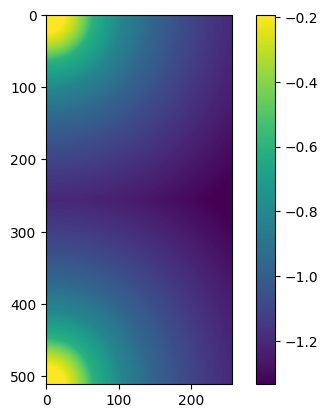

In [8]:

#visualize transfer func
%pylab inline
imshow(np.log10(Plin))
colorbar()
show()


In [9]:
from jax import jit, checkpoint, custom_vjp
from functools import partial

In [10]:
nx = nc
ny = nc

kx = jnp.ones(k.shape)*kvec[0]
ky = jnp.ones(k.shape)*kvec[1]
from jax import jit, checkpoint, custom_vjp

@jit
@checkpoint
def linear_modes(modes, theta):
    kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
    k = jnp.sqrt(sum(k**2 for k in kvec))

    Plin = power3d(k, theta)
    
    if jnp.isrealobj(modes):
        modes = jnp.fft.rfftn(modes, norm='ortho')
    modes *= jnp.sqrt(Plin)#*jnp.sqrt(10)
    return modes


def gen_map_den2d(theta,z):
    modes_e = z[:nx*ny].reshape((nx,ny))
    
    theta_e = theta[:nmodes-1]
    
    phi_e = linear_modes(modes_e, theta_e)
  
    return jnp.fft.irfftn(phi_e )#Need to check normalization



In [11]:
error_val=1.0

def sample_x_z(key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nx*ny,))
        x = (gen_map_den2d(θ,z) + error_val*jax.random.normal(keys[1], (nx,ny))) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
        return (x, z)

In [12]:
stheta = jnp.array(bp)

(xx,zz) = sample_x_z(rng_key,stheta)

/tmp/ipykernel_661291/2948050034.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))


In [29]:
x = xx

n_bp = nmodes-1

def logLike_MCHMC(v):
        z = v[n_bp:]
        
        #θ = stheta
        θ = v[:n_bp]
        #θ=θ.at[1].set(v[1])
        return logLike(z,θ)+logPrior(θ)

def logLike(z, θ):
        return -(jnp.sum((x - gen_map_den2d(θ,z))**2) + jnp.sum(z**2.0))

def logPrior(θ): #20% error on power spectra prior
        return -1/2.*jnp.sum(((θ-jnp.array(bp))/(0.2*bp))**2)
    

In [30]:
(xx,zz) = sample_x_z(rng_key,jnp.array(bp))

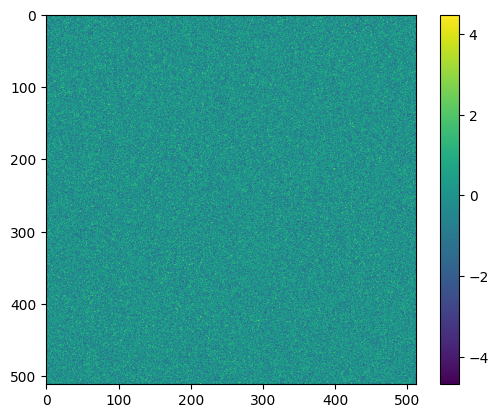

In [31]:
imshow(xx)
colorbar()

In [32]:
### import time

initial_position = numpy.random.rand(
    nx*ny+n_bp)

initial_position[:n_bp] = stheta
initial_position[n_bp:]= zz

initial_position= jnp.array(initial_position)

init_key, run_key = jax.random.split(rng_key, 2)


In [33]:
logLike(zz,stheta)

Array(-525190.75, dtype=float32)

In [34]:
logLike_MCHMC(initial_position)

Array(-525190.75, dtype=float32)

In [35]:
test = jax.value_and_grad(logLike_MCHMC)

In [36]:
test(initial_position)[1]

Array([-0.11091764,  0.5795637 ,  0.15235099, ...,  1.8283701 ,
        0.02834096, -0.37915754], dtype=float32)

In [37]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov=sqrt_diag_cov,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples, _ = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples

In [40]:
# run the algorithm on a high dimensional gaussian, and show two of the dimensions

sample_key, rng_key = jax.random.split(rng_key)
samples = run_mclmc(
    logdensity_fn=logLike_MCHMC,
    num_steps=1000,
    initial_position=initial_position,
    key=sample_key,
    transform=lambda state: state.position,
)
samples.mean()

Array(nan, dtype=float32)

In [41]:
samples[:,0]

Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [ ]:
## trying now with HMC

In [43]:
inv_mass_matrix = 0.1*np.ones(initial_position.shape)
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logLike_MCHMC, step_size, inv_mass_matrix, num_integration_steps)

In [44]:
initial_state = hmc.init(initial_position)

In [45]:
hmc_kernel = jax.jit(hmc.step)


In [46]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [47]:

rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position